In [1]:
import sys

sys.path.append("../")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [3]:
import neural.binary_modules as bm
import utilities as utils

#### Trainloop

In [4]:
def plot_values(values, subplot=None, **kwargs):
    # clear_output(True)
    if subplot:
        plt.subplot(*subplot)
  
    plt.plot(np.arange(len(values)) + 1, values, **kwargs)
    plt.xlabel("n_epoch")
    plt.legend()
    # plt.show()


def matrix_accuracy(A: np.array, B: np.array):
    assert A.shape == B.shape
    return 1 - np.sum(np.abs(A - B)) / A.size


def density(A: np.array):
    return A.sum() / np.size(A)

In [32]:
def train_over_matrix(matrix, model, criterion, optimizer,
                      batch_size=16, n_epochs=10, draw_plots=True):
    
    train_loader = DataLoader(utils.matrix_to_ids(matrix), batch_size=batch_size)
    losses_per_epoch = list()
    fact_acc = list()
    intermediate_user_factors = list()
    intermediate_item_factors = list()
    user_emb_grads = list()       # user_embedding.weight
    item_emb_grads = list()       # item_embedding.weight
    approx_densities = list()

    for epoch in tqdm(range(n_epochs)):
        losses_per_batch = list()

        for i, batch in enumerate(train_loader):
            model_output = model(batch)
            target = batch[:, 2].float()

            optimizer.zero_grad()
            train_loss = criterion(model_output, target)
            train_loss.backward()
            # if epoch % 20 == 0:
            #     user_emb_grads.append(torch.norm(list(model.parameters())[0].grad))
            #     item_emb_grads.append(torch.norm(list(model.parameters())[1].grad))
            optimizer.step()
            losses_per_batch.append(train_loss.detach().numpy())
            
        losses_per_epoch.append(np.array(losses_per_batch).mean())

        if draw_plots:
            clear_output(True)
            plt.figure(figsize=(12, 11))
            plot_values(losses_per_epoch, subplot=(3, 2, 1), label=str(criterion), color="green")
            plot_values(fact_acc, subplot=(3, 2, 2), label="Factorization accuracy", color="maroon")
            plot_values(user_emb_grads, subplot=(3, 2, 3), label="User gradient magnitude", color="orange")
            plot_values(item_emb_grads, subplot=(3, 2, 4), label="Item gradient magnitude", color="orange")
            plot_values(approx_densities, subplot=(3, 2, 5), label="Approx. density", color="indigo")
            plt.show()
        
        if epoch % 10 == 0:    # was 10
            # Calculating factorization error and factorization density
            temp_user_factor, temp_item_factor = model.get_factors()
            approx_matrix = utils.bin_matmul_1(temp_user_factor, temp_item_factor.T)
            fact_acc.append(matrix_accuracy(approx_matrix, matrix.numpy()))
            approx_densities.append(density(approx_matrix))
            
        if epoch % 10 == 0:   # was 20
            intermediate_user_factors.append(temp_user_factor)
            intermediate_item_factors.append(temp_item_factor)
            

    user_bin_factor, item_bin_factor = model.get_factors()

    output = {
        "user_bin_factor": user_bin_factor,
        "item_bin_factor": item_bin_factor,
        "losses_per_epoch": losses_per_epoch,
        "fact_acc": fact_acc,
        "iuf": intermediate_user_factors,
        "iif": intermediate_item_factors,
        "user_emb_grads": user_emb_grads,
        "item_emb_grads": item_emb_grads
    }

    return output

#### Model

In [6]:
from typing import Tuple

In [48]:
class GeneralizedMatrixFactorization(nn.Module):
    def __init__(self, n_users: int, n_items: int, embedding_dim: int) -> None:
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        # self.user_embedding = bm.BinarizedEmbedding(n_users, embedding_dim)
        # self.item_embedding = bm.BinarizedEmbedding(n_items, embedding_dim)

        self._init_weight()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x -> (batch_size, 3)
        users = x[:, 0]    # -> (b_size)
        items = x[:, 1]    # -> (b_size)

        user_vectors = (self.user_embedding(users) + 1) / 2    # -> (b_size, emb_dim)
        item_vectors = (self.item_embedding(items) + 1) / 2    # -> (b_size, emb_dim)

        return torch.mul(user_vectors, item_vectors)    # -> (b_size, emb_dim)

    def _init_weight(self):
        nn.init.xavier_uniform_(self.user_embedding.weight)     # default distribution - normal
        nn.init.xavier_uniform_(self.item_embedding.weight)


class MultiLayerPerceptron(nn.Module):
    def __init__(self, n_users: int, n_items: int, embedding_dim: int,
                 mlp_layers: Tuple[int, ...]) -> None:
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)

        self.MLP = self._make_layers(layers=mlp_layers, embedding_dim=embedding_dim)
        self._init_weight()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x -> (b_size, 3)
        users = x[:, 0]    # -> (b_size)
        items = x[:, 1]    # -> (b_size)

        user_vectors = self.user_embedding(users)    # -> (b_size, emb_dim)
        item_vectors = self.item_embedding(items)    # -> (b_size, emb_dim)

        concat_vectors = torch.concat((user_vectors, item_vectors), dim=1)    # -> (b_size, 2 * emb_dim)

        return self.MLP(concat_vectors)    # -> (b_size, mlp_layers[-1])

    def _make_layers(self, layers: Tuple[int, ...], embedding_dim: int) -> nn.Module:
        if not layers:
            raise ValueError("should have at least one mlp layer.")

        mlp_layers = nn.Sequential()
        past_dims = embedding_dim * 2

        for layer in layers:
            mlp_layers.append(nn.Linear(past_dims, layer))
            mlp_layers.append(nn.ReLU())
            past_dims = layer

        return mlp_layers

    def _init_weight(self):
        pass


class NeuralMatrixFactorization(nn.Module):
    def __init__(self, n_users: int, n_items: int, GMF_embedding_dim: int, MLP_embedding_dim: int,
                 mlp_layers: Tuple[int, ...]) -> None:
        super().__init__()
        self.GMF = GeneralizedMatrixFactorization(
            n_users=n_users, n_items=n_items, embedding_dim=GMF_embedding_dim
        )
        self.MLP = MultiLayerPerceptron(
            n_users=n_users,
            n_items=n_items,
            embedding_dim=MLP_embedding_dim,
            mlp_layers=mlp_layers,
        )

        # self.predict_layer = nn.Linear(GMF_embedding_dim + mlp_layers[-1], 1)
        self.predict_layer = nn.Linear(GMF_embedding_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x -> (b_size, 3)
        gmf_vectors = self.GMF(x)    # -> (b_size, emb_dim)
        # mlp_vectors = self.MLP(x)    # -> (b_size, mlp_layers[-1])

        # concat_vectors = torch.concat((gmf_vectors, mlp_vectors), dim=1)    # -> (b_size, emb_dim + mlp_layers[-1])
        output = self.predict_layer(gmf_vectors)                         # -> (b_size, 1)

        return self.sigmoid(output).squeeze()    # -> (b_size)

In [53]:
class BMFLarge_dev(nn.Module):
    def __init__(self, n_users: int, n_items: int, embedding_dim: int,
                 hidden_dim: int, output_act: str, init_weights: bool, **kwargs) -> None:
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)

        self.user_linear_1 = nn.Linear(embedding_dim, hidden_dim)
        self.user_linear_2 = nn.Linear(hidden_dim, embedding_dim)
        self.item_linear_1 = nn.Linear(embedding_dim, hidden_dim)
        self.item_linear_2 = nn.Linear(hidden_dim, embedding_dim)

        self.sigm = nn.Sigmoid()
        self.relu = nn.ReLU()

        if output_act == "shifted_sigmoid":
            self.output_act = lambda prod: bm.shifted_sigmoid(torch.sum(prod, axis=1)) 
        elif output_act == "shifted_tanh":
            self.output_act = lambda prod: bm.shifted_scaled_tanh(torch.sum(prod, axis=1), coef=kwargs["tanh_coef"])
        elif output_act == "maxpool":
            self.pooling = nn.MaxPool1d(kernel_size=embedding_dim)
            self.output_act = lambda prod: self.pooling(prod).squeeze(1)
        elif output_act == "dense_layer":
            self.dense_1 = nn.Linear(hidden_dim, 16)
            self.dense_2 = nn.Linear(16, 1)
            self.output_act = lambda prod: self.sigm(self.dense_2(self.sigm(self.dense_1(prod)))).squeeze(1)
        
        if init_weights: self._init_weight()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x -> (b_size, 3)
        users = x[:, 0]    # -> (b_size)
        items = x[:, 1]    # -> (b_size)

        user_vectors = self.relu((self.user_linear_1(self.sigm(self.user_embedding(users)))))     # -> (b_size, emb_dim)
        # user_vectors = (bm.binarized(self.user_linear_2(user_vectors)) + 1) / 2        # -> (b_size, emb_dim)
        user_vectors = (torch.tanh(self.user_linear_2(user_vectors)) + 1) / 2
        item_vectors = self.relu((self.item_linear_1(self.sigm(self.item_embedding(items)))))       # -> (b_size, emb_dim)
        # item_vectors = (bm.binarized(self.item_linear_2(item_vectors)) + 1) / 2        # -> (b_size, emb_dim)
        item_vectors = (torch.tanh(self.item_linear_2(item_vectors)) + 1) / 2
        
        prod = torch.mul(user_vectors, item_vectors)                                   # -> (b_size)
        res = self.output_act(prod)                                                    # -> (b_size)
            
        return res
    
    def get_factors(self, raw=False):
        '''
        Extracts current (binary / raw) factor-matrices for users and for items
        '''
        with torch.no_grad():
            user_raw = self.relu(self.user_linear_1(self.sigm((self.user_embedding.weight))))
            user_raw = self.user_linear_2(user_raw)
            item_raw = self.relu(self.item_linear_1(self.sigm((self.item_embedding.weight))))
            item_raw = self.item_linear_2(item_raw)

            if raw:
                return user_raw.detach().clone().numpy(), item_raw.detach().clone().numpy()
            
            user_bin = (np.sign(user_raw.detach().clone().numpy()) + 1) / 2
            item_bin = (np.sign(item_raw.detach().clone().numpy()) + 1) / 2

            return user_bin, item_bin

    def _init_weight(self):
        nn.init.xavier_uniform_(self.user_linear_1.weight)     # default distribution - normal
        nn.init.xavier_uniform_(self.user_linear_2.weight)
        nn.init.xavier_uniform_(self.item_linear_1.weight)
        nn.init.xavier_uniform_(self.item_linear_2.weight)

#### Explorations

In [56]:
n_users = 6
n_items = 6
emb_size = 4
matrix = utils.get_binary_tensor((n_users, n_items))
# matrix = torch.eye(6, dtype=torch.int8)

model = BMFLarge_dev(
    n_users=n_users,
    n_items=n_items,
    embedding_dim=emb_size,
    hidden_dim=64,
    init_weights=False,
    output_act="shifted_tanh",
    tanh_coef=3
)

# criterion = nn.MSELoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

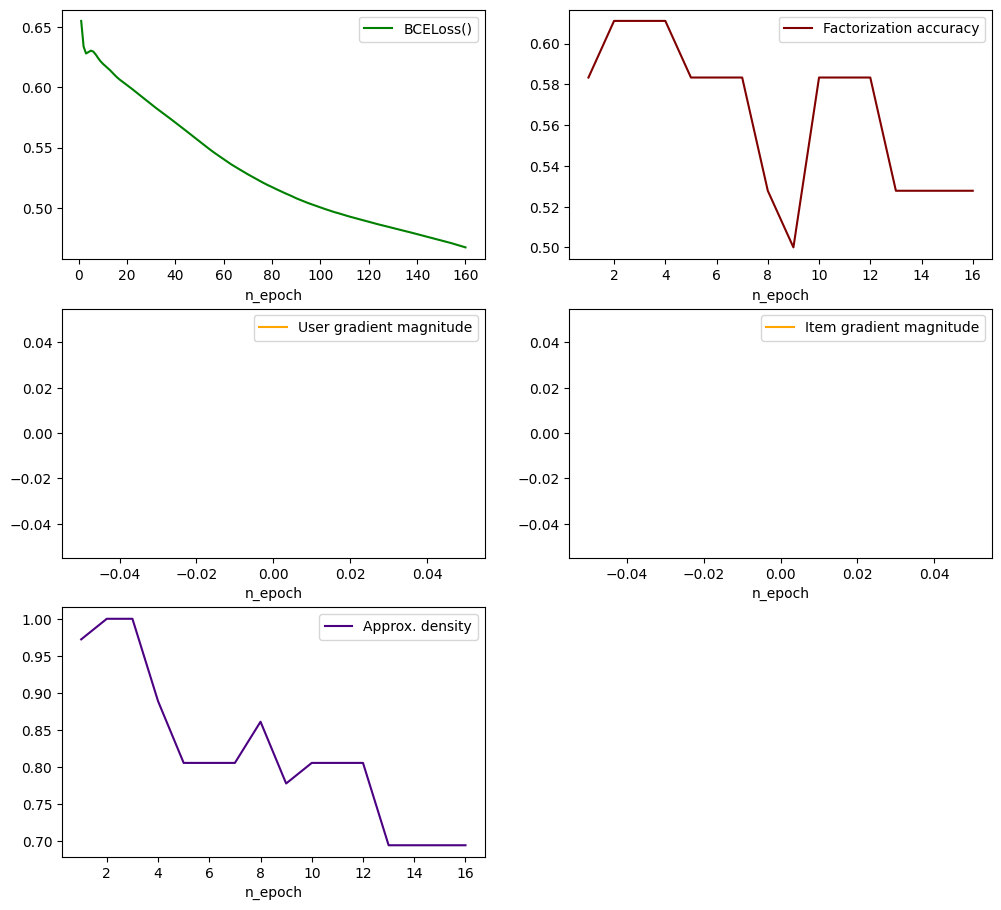

In [57]:
output = train_over_matrix(
    matrix=matrix,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    batch_size=32, n_epochs=160,
    draw_plots=True              
)

In [26]:
model.get_factors()

(array([[0., 0., 0., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [1., 0., 1., 1.]], dtype=float32),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=float32))

#### Pure NCF testing

In [49]:
n_users = 6
n_items = 6
emb_size = 4
matrix = utils.get_binary_tensor((n_users, n_items))
# matrix = torch.eye(6, dtype=torch.int8)

model = NeuralMatrixFactorization(
    n_users=n_users,
    n_items=n_items,
    GMF_embedding_dim=emb_size,
    MLP_embedding_dim=emb_size,
    mlp_layers=[32, 32]
)

# criterion = nn.MSELoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

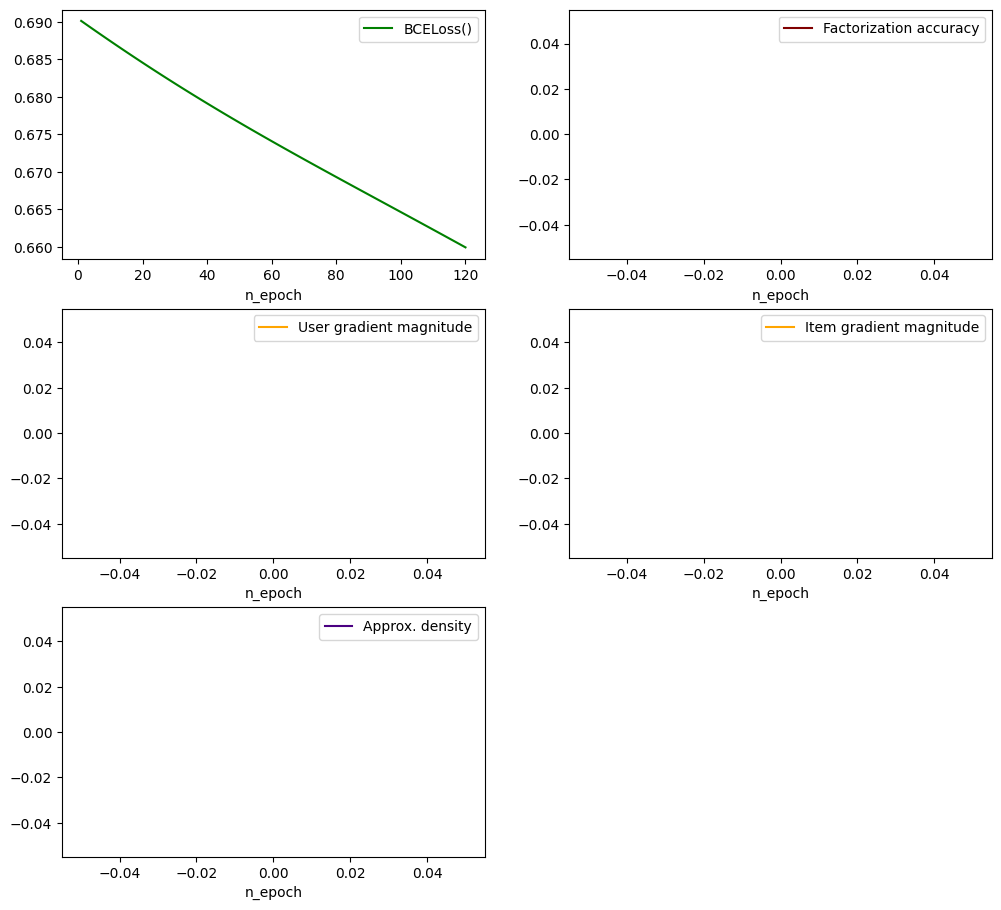

In [50]:
output = train_over_matrix(
    matrix=matrix,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    batch_size=36, n_epochs=120,
    draw_plots=True               # no dynamic plotting here
)

In [40]:
print(list(model.parameters())[0].grad)

None
